In [1]:
import pyabf
import matplotlib.pyplot as plt
import numpy as np
from os import getcwd,listdir
from util import findStable_Bias, cal_points_qty, print_points_qty, plot_wave, plot_colormap, capture, write_target

# Start

##### V2: Include Bias
* 800mV 22214004.abf: 3120 + 4(start) + 3(end) = 3127
* 700mV 22214005.abf: 3120 + 6(start) = 3126
* 200mV 22318006.abf: 3120 + 5(start) = 3125
* 500mV 22304010.abf:
* 200mV 22323007.abf: 3120 + 
* 200mV 22504024.abf: 3120 + 12(start) = 3132
* 600mV 22519010.abf: 3120 + 3(start)= 3123 #Care for time: 36818519 36818524
### V1: Not include Bias

* 800mV 21n05000.abf: 3120 + 4(start) = 3124
* 700mV 21n05001.abf: 3120 + 4(start) + 41(end) = 3165 
* 600mV 21n05002.abf: 3120 + 4(start) = 3124
* 500mV 21n05003.abf: 3120 + 6(start) + 21(end) = 3147
* 400mV 21n05004.abf: Last point have only close, 3120+5(start)+1(end) = 3126
* 300mV 21n05005.abf: 3120 + 4(start) + 39(end) = 3163
* 600mV 21930014.abf: 3120 + 5(start)  = 3125
* 800mV 21d04000.abf: 3120 + 6(start) + 30(end) =3156

In [2]:
abf_file = ["24903000.abf","24903001.abf"]

In [3]:
abf = [pyabf.ABF("abf\\"+x) for x in abf_file]
title_prefix = [x[:-4] for x in abf_file]
fig_save_path =getcwd()+"\\result\\"

In [4]:
bins = [50,50]
# start_ignore and end_ignore: extra points before reshape into rows
# start_extra and end_extra: extra points of each rows
start_ignore = [2,2] #Don't include the single point
end_ignore = [12,13]  #Don't include the single point
start_extra = [5,5]
end_extra = [0,0]
first_row_repeat = [6,6]
volt = [200,-200]
Row = [100,100]
Col = [100,100]
start_single = [True,True]
end_single = [False,False]
emf_bias = [-300,-140]
current_bias = [0,0]

In [5]:
ignore = [(x,y) for x,y in zip(start_ignore,end_ignore)]
extra =  [(x,y) for x,y in zip(start_extra,end_extra)]
dim = [(x-1,y) for x,y in zip(Row,Col)]
single = [(x,y) for x,y in zip(start_single,end_single)]

In [6]:
for i in range(len(title_prefix)):
    total = (Row[i]-1)*(Col[i]+start_extra[i]+end_extra[i])+end_ignore[i]+start_ignore[i]+Col[i]*first_row_repeat[i]
    print(f"{abf_file[i]}'s total points should be {total}")

24903000.abf's total points should be 11009
24903001.abf's total points should be 11010


In [7]:
closes = []
fars = []
close_inds = []
end_inds = []
for i in range(len(abf)):
    close,far,close_index,end_index = findStable_Bias(abf[i],volt[i],single=single[i])
    closes.append(close)
    fars.append(far)
    close_inds.append(close_index)
    end_inds.append(end_index)

Close point found: 11009
Far point found: 11009
Close point found: 11010
Far point found: 11010


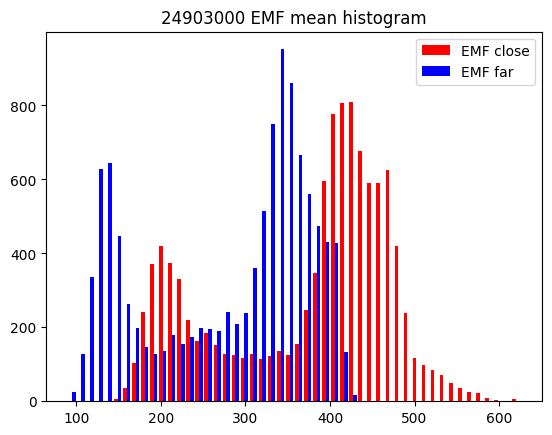

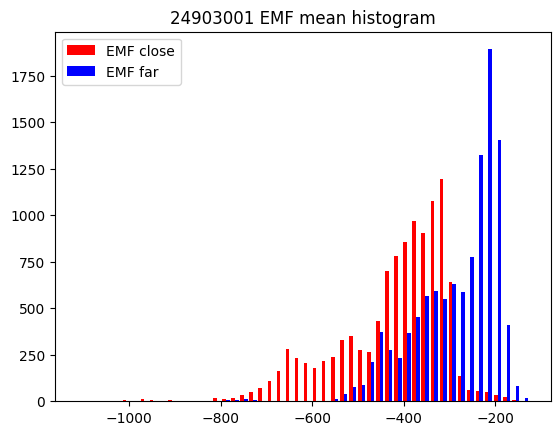

In [8]:
for i in range(len(abf_file)):
    plt.figure()
    plt.hist((closes[i],fars[i]),bins=bins[i],label = ('EMF close','EMF far'),color = ('red','blue'))
    plt.legend()
    plt.title("%s EMF mean histogram"%(title_prefix[i]))
    plt.savefig(fig_save_path+"%s EMF mean histogram"%(title_prefix[i]))
    plt.show()

1.371584 ± 0.263110
1.534225 ± 0.172803


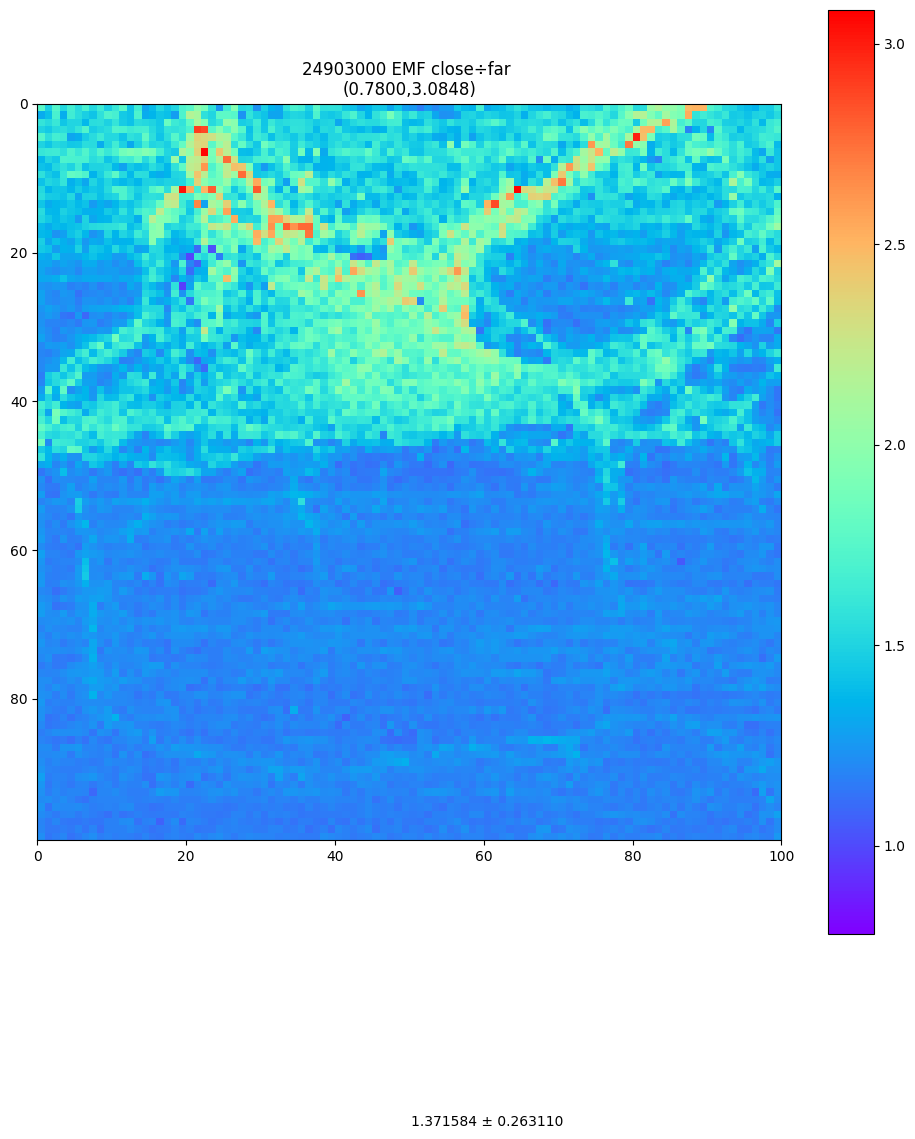

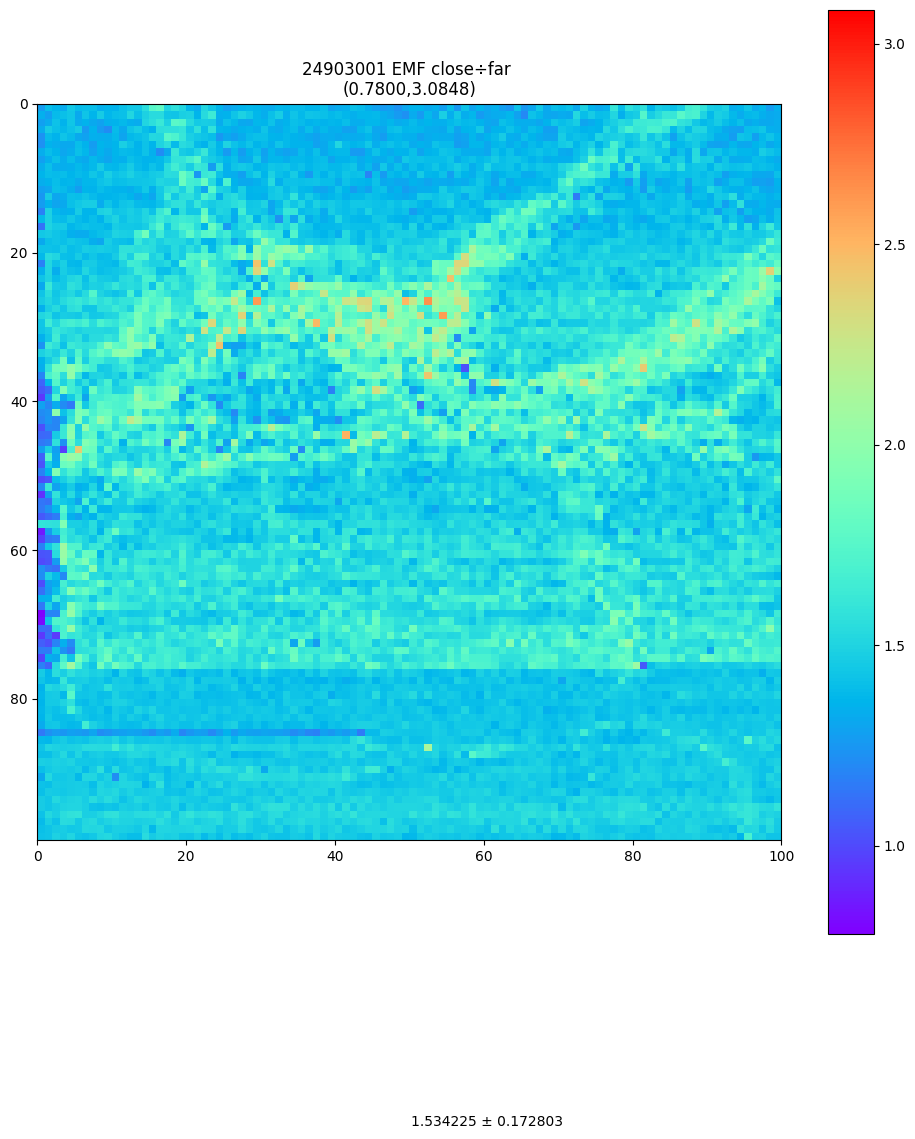

In [71]:
emf_divs = []
vmins = []
vmaxs = []
for i in range(len(abf_file)):
    target = closes[i]/fars[i]
    target = capture(target, first_row_repeat[i], ignore[i], extra[i], dim[i])
    mean = np.mean(target)
    std = np.std(target)
    print(f"%lf ± %lf" %(mean,std))
    emf_divs.append(target)
    vmins.append(target.min())
    vmaxs.append(target.max())
    
vmin = min(vmins)
vmax = max(vmaxs)
for i in range(len(abf_file)):
    figsize = (int(emf_divs[i].shape[0]/8), int(emf_divs[i].shape[1]/8))
    title = title_prefix[i] + " EMF close÷far"
    plot_colormap(emf_divs[i],title = title,path = fig_save_path, figsize = figsize,
                  vmin = vmin, vmax = vmax)

92.215294 ± 48.816940
-143.282501 ± 43.542435


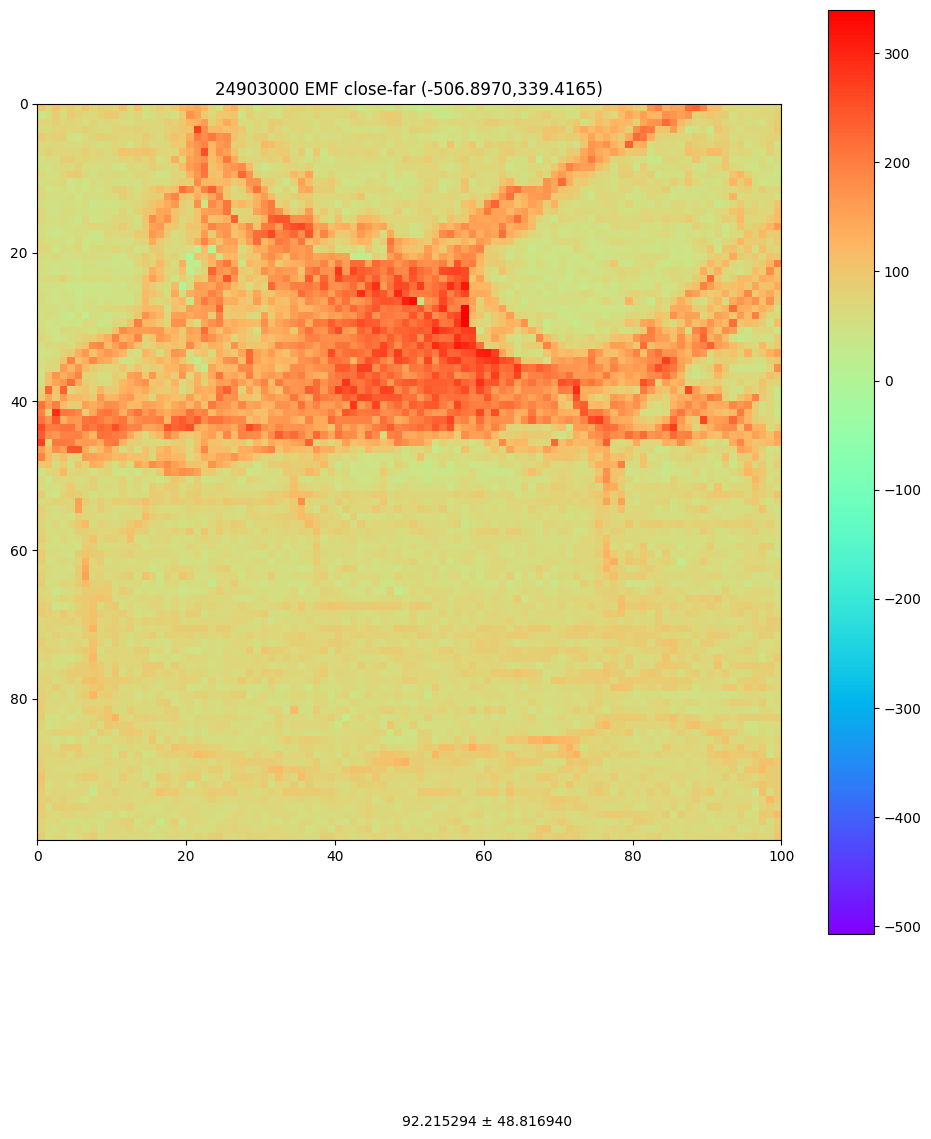

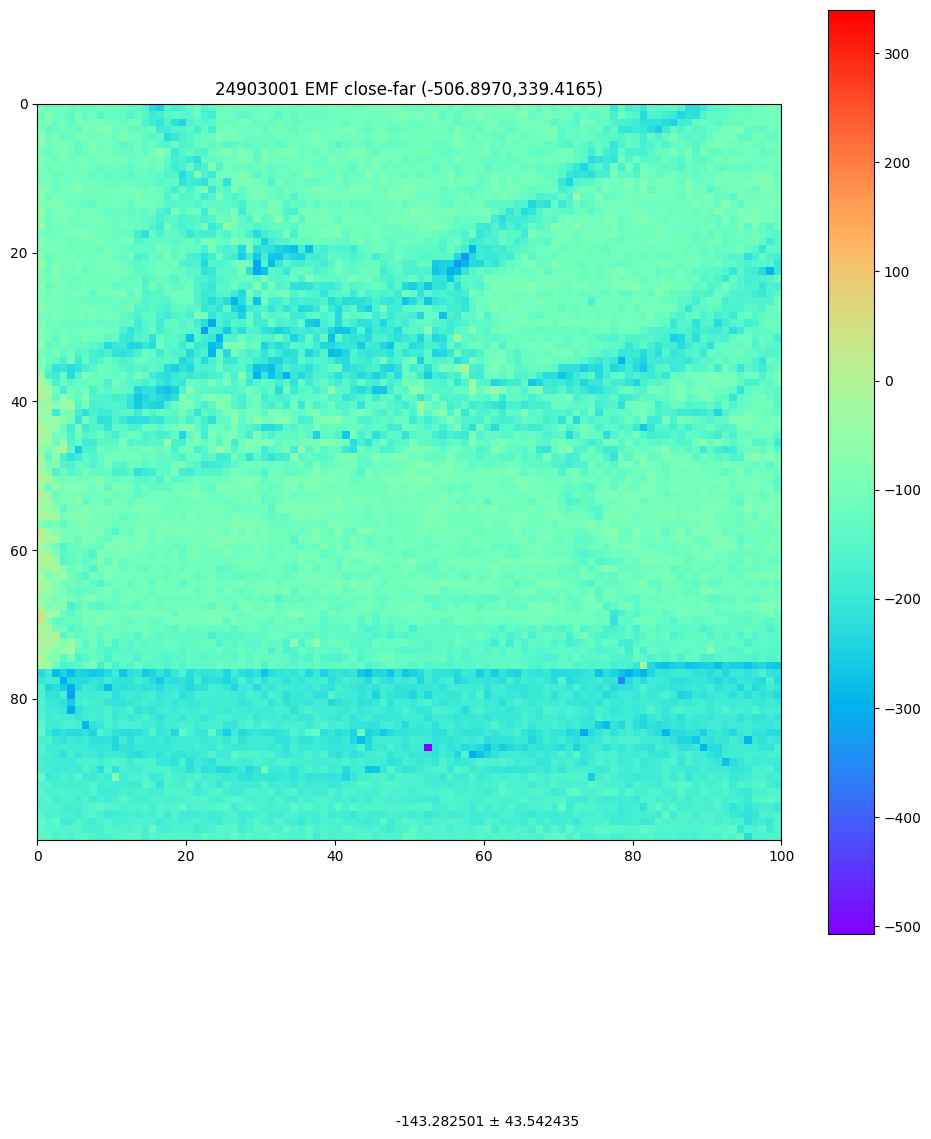

In [69]:
emf_difs = []
vmins = []
vmaxs = []
for i in range(len(abf_file)):
    target = closes[i]-fars[i]
    target = capture(target, first_row_repeat[i], ignore[i], extra[i], dim[i])
    mean = np.mean(target)
    std = np.std(target)
    print(f"%lf ± %lf" %(mean,std))
    emf_difs.append(target)
    vmins.append(target.min())
    vmaxs.append(target.max())
    
vmin = min(vmins)
vmax = max(vmaxs)
for i in range(len(abf_file)):
    figsize = (int(emf_difs[i].shape[0]/8), int(emf_difs[i].shape[1]/8))
    title = title_prefix[i] + " EMF close-far"
    plot_colormap(emf_difs[i],title = title,path = fig_save_path, figsize = figsize,
                  vmin = vmin, vmax = vmax)

In [11]:
# Calculate on Current
I_closes = []
I_fars = []
I_close_inds = []
I_end_inds = []
for i in range(len(abf)):
    close,far,close_index,end_index = findStable_Bias(abf[i],volt[i],single=single[i], channel = 0)
    I_closes.append(close)
    I_fars.append(far)
    I_close_inds.append(close_index)
    I_end_inds.append(end_index)

Close point found: 11009
Far point found: 11009
Close point found: 11010
Far point found: 11010


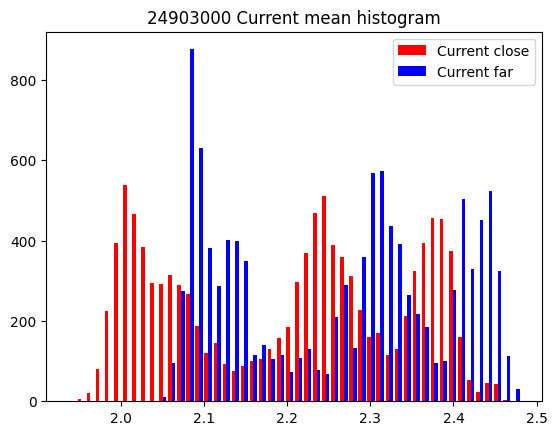

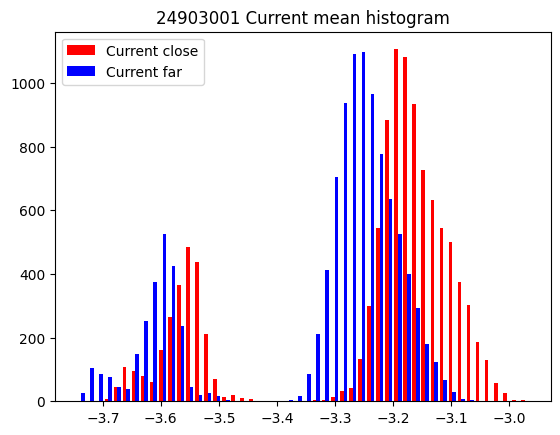

In [12]:
for i in range(len(abf_file)):
    plt.figure()
    plt.hist((I_closes[i],I_fars[i]),bins=bins[i],label = ('Current close','Current far'),color = ('red','blue'))
    plt.legend()
    plt.title("%s Current mean histogram"%(title_prefix[i]))
    plt.savefig(fig_save_path+"%s Current mean histogram"%(title_prefix[i]))
    plt.show()

0.971966 ± 0.008067
0.975680 ± 0.008436


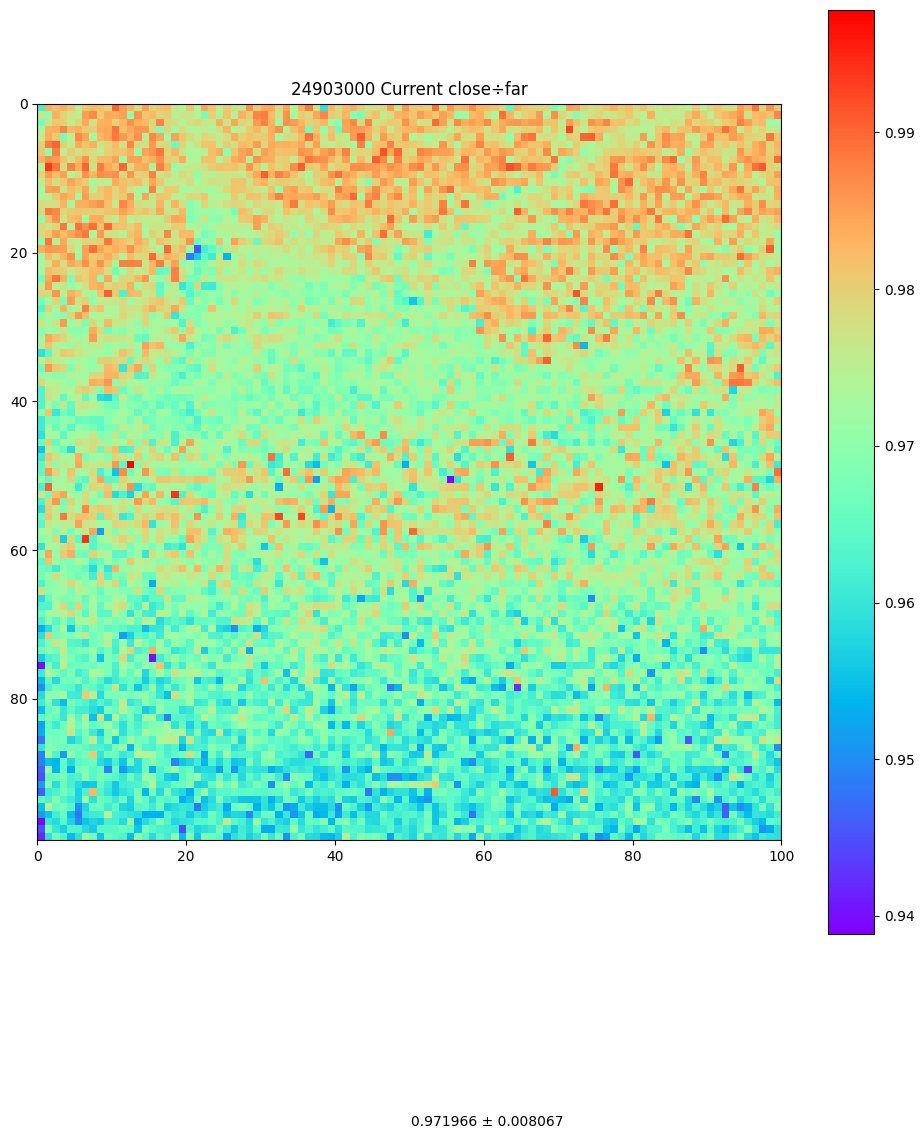

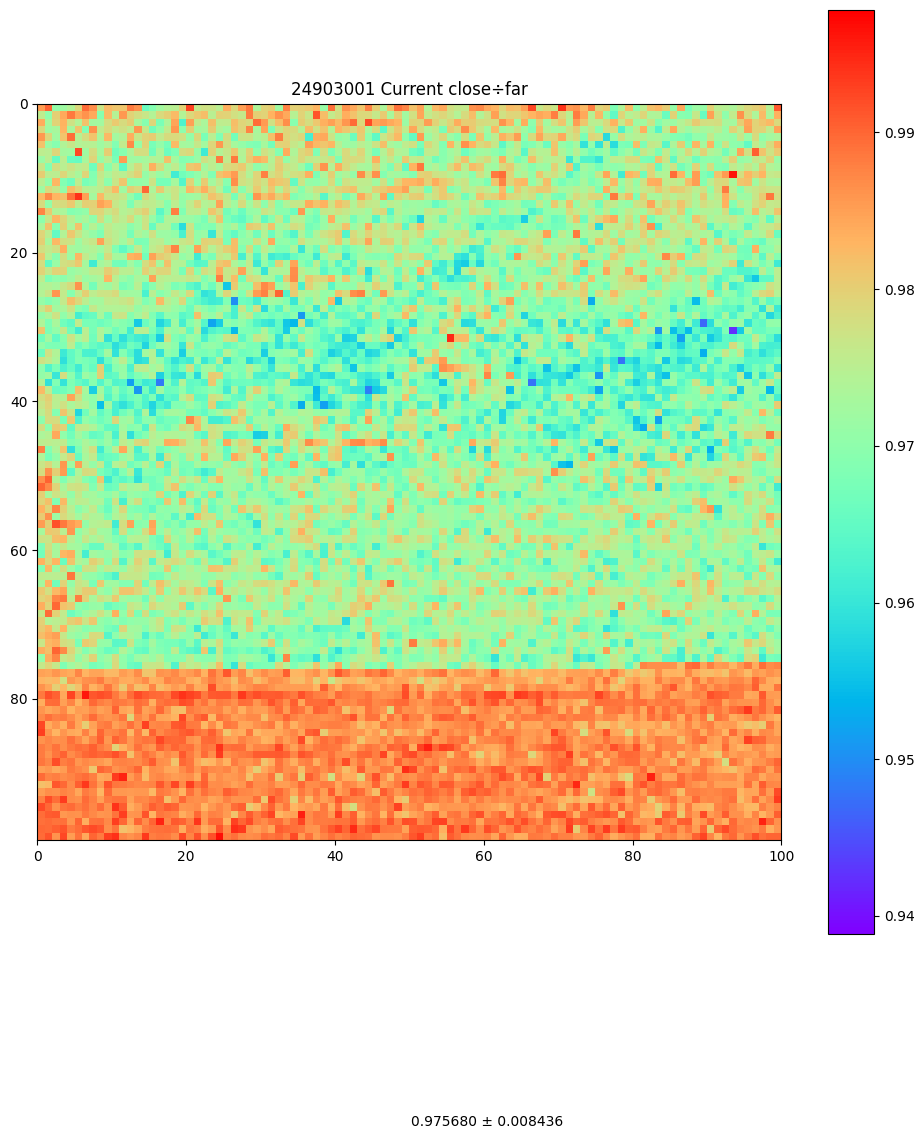

In [13]:
cur_divs = []
vmins = []
vmaxs = []
for i in range(len(abf_file)):
    target = I_closes[i]/I_fars[i]
    target = capture(target, first_row_repeat[i], ignore[i], extra[i], dim[i])
    mean = np.mean(target)
    std = np.std(target)
    print(f"%lf ± %lf" %(mean,std))
    cur_divs.append(target)
    vmins.append(target.min())
    vmaxs.append(target.max())
    
vmin = min(vmins)
vmax = max(vmaxs)
for i in range(len(abf_file)):
    figsize = (int(cur_divs[i].shape[0]/8), int(cur_divs[i].shape[1]/8))
    title = title_prefix[i] + " Current close÷far"
    plot_colormap(cur_divs[i],title = title,path = fig_save_path, figsize = figsize,
                  vmin = vmin, vmax = vmax)

-0.062369 ± 0.015840
0.080059 ± 0.025999


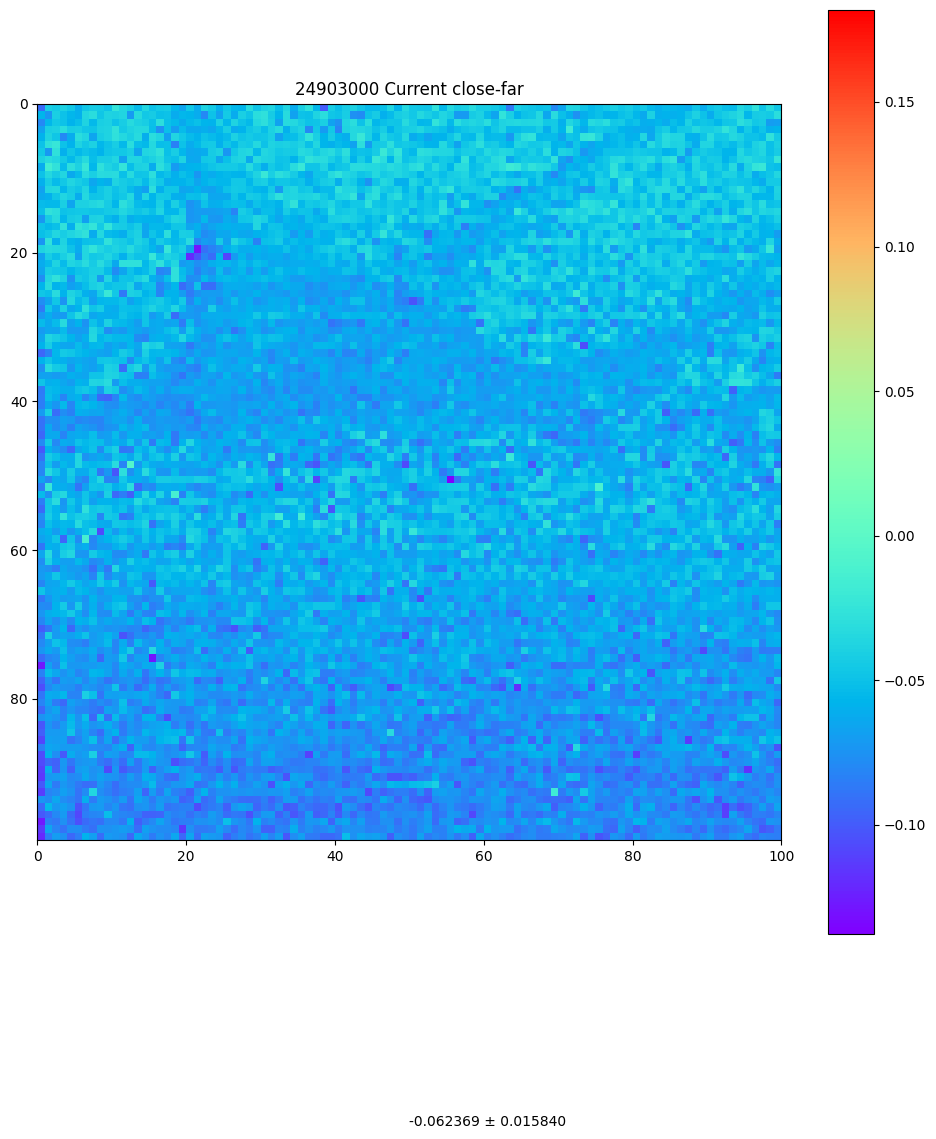

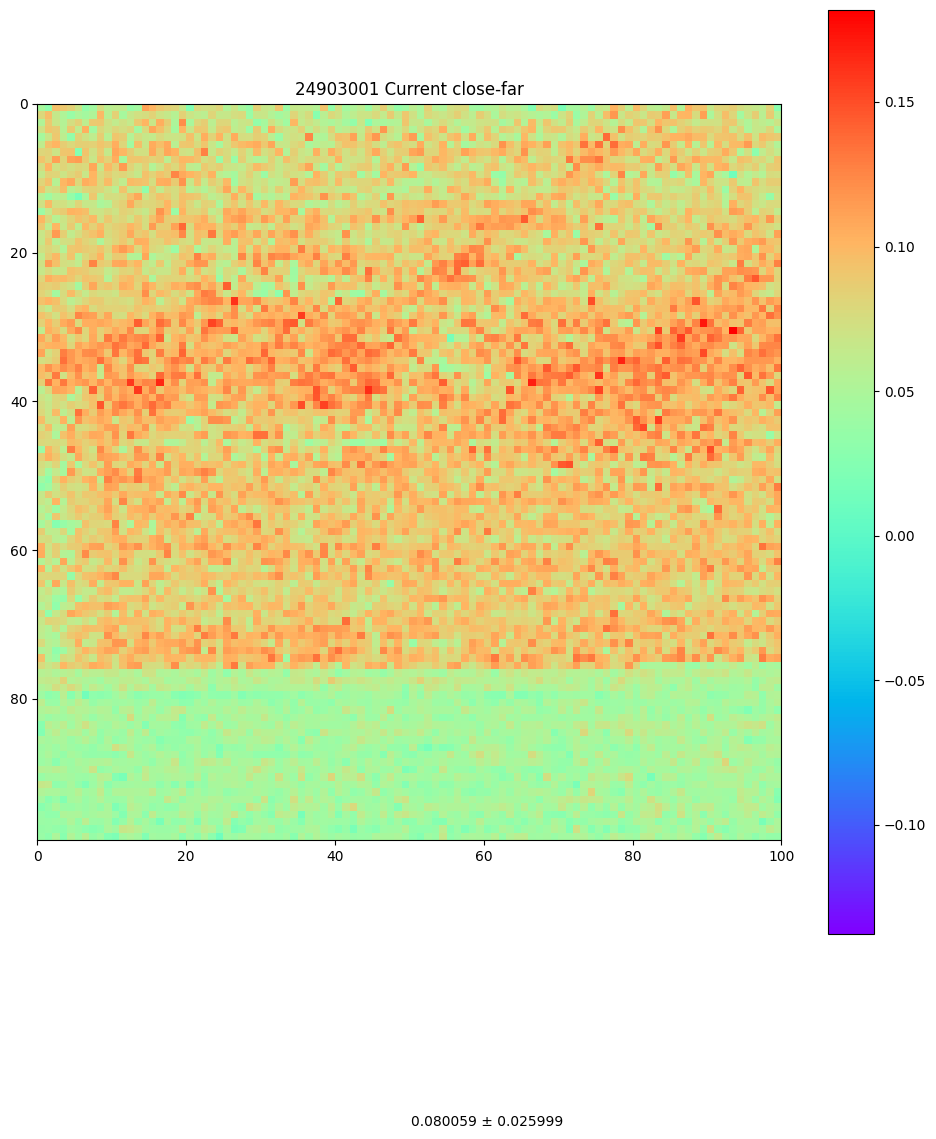

In [14]:
cur_difs = []
vmins = []
vmaxs = []
for i in range(len(abf_file)):
    target = I_closes[i]-I_fars[i]
    target = capture(target, first_row_repeat[i], ignore[i], extra[i], dim[i])
    mean = np.mean(target)
    std = np.std(target)
    print(f"%lf ± %lf" %(mean,std))
    cur_difs.append(target)
    vmins.append(target.min())
    vmaxs.append(target.max())
    
vmin = min(vmins)
vmax = max(vmaxs)
for i in range(len(abf_file)):
    figsize = (int(cur_difs[i].shape[0]/8), int(cur_difs[i].shape[1]/8))
    title = title_prefix[i] + " Current close-far"
    plot_colormap(cur_difs[i],title = title,path = fig_save_path, figsize = figsize,
                  vmin = vmin, vmax = vmax)

In [30]:
emf = []
cur = []
for i in range(len(abf_file)):
    emf.append(np.vstack((closes[i].flatten(),fars[i].flatten())))
    emf[i] = emf[i].reshape((emf[i].shape[1],emf[i].shape[0]))
    cur.append(np.vstack((I_closes[i].flatten(),I_fars[i].flatten())))
    cur[i] = cur[i].reshape((cur[i].shape[1],cur[i].shape[0]))

In [53]:
closes_2d = []
fars_2d = []
I_closes_2d = []
I_fars_2d = []
for i in range(len(abf_file)):
    closes_2d.append(capture(closes[i], first_row_repeat[i], ignore[i], extra[i], dim[i]))
    fars_2d.append(capture(fars[i], first_row_repeat[i], ignore[i], extra[i], dim[i]))
    I_closes_2d.append(capture(I_closes[i], first_row_repeat[i], ignore[i], extra[i], dim[i]))
    I_fars_2d.append(capture(I_fars[i], first_row_repeat[i], ignore[i], extra[i], dim[i]))

In [62]:
import pandas as pd
import csv
for i in range(len(abf_file)):
    targets = [emf_divs[i], emf_difs[i], closes_2d[i], fars_2d[i], cur_divs[i], cur_difs[i], I_closes[i], I_fars[i], emf[i], cur[i]]
    filenames = [" EMF close÷far"," EMF close-far", "EMF close", "EMF far",
                 " Current close÷far"," Current close-far", " Current close", " Current far", " EMF", " Current"]
    filenames = [title_prefix[i]+x+" " for x in filenames]
    for target, filename in zip(targets,filenames):
        write_target(target,filename)

# Test

## Test 01 -- With start time and end time

TypeError: analysis_Bias() got multiple values for argument 'timeStart'

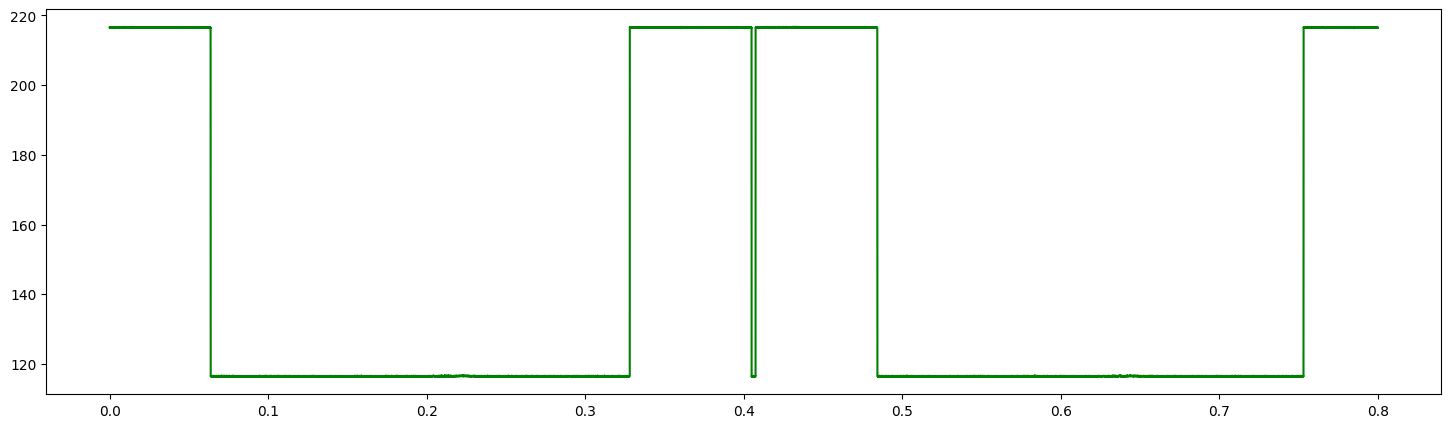

In [34]:
timeStart = 0
timeEnd = 20000
ind = 0
plot_wave(abf[ind],volt[ind],timeStart = timeStart, timeEnd = timeEnd,channel=4)
print(abf[ind].sweepY[timeStart:timeEnd])

In [ ]:
#Test
abfFile = "23428006.abf"
volt = 500
abf = pyabf.ABF("..\\data\\0727\\23428006\\"+abfFile)
plot_v2(abf,volt,timeStart = 0,timeEnd = 4000,channel=2)
plot_v2(abf,volt,timeStart = 0 ,timeEnd = 4000,channel=4)

## Test 02_v2 -- Check all graph

In [ ]:
interval = 200000
abfFile = "23428006.abf"
volt = 500
abf = pyabf.ABF("..\\data\\0727\\23428006\\"+abfFile)
for i in range(0,len(abf.sweepY),interval):
    print("Time: %d ~ %d"%(i,i+interval+50))
    timeStart = i
    timeEnd = i+interval+50
    close_qty,far_qty = plot_v2(abf,volt,timeStart = timeStart, timeEnd = timeEnd,channel = 4)

## Test 03_v3--Check Total Points Collected in each (x,y)

In [ ]:
abfFile = "23428006.abf"
volt = 500
abf = pyabf.ABF("..\\data\\0727\\23428006\\"+abfFile)
mat = print_points_qty(abf,end_index)